In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import sys
sys.path.append('..')
from LogisticRegression import LogisticRegression
from sklearn.metrics import accuracy_score

# Read the dataset

In [119]:
df = pd.read_csv('../fracture.csv')
df.head()

,id,sex,fracture,duration,age,wt,ht,bmi,Tscores,fnbmd,lsbmd,fall,priorfracture,death
0,3,M,0,0.55,73,98.0,175.0,32.0,0.33,1.08,1.458,1,0,1
1,8,F,0,15.38,68,72.0,166.0,26.0,-0.25,0.97,1.325,0,0,0
2,9,M,0,5.06,68,87.0,184.0,26.0,-0.25,1.01,1.494,0,0,1
3,10,F,0,14.25,62,72.0,173.0,24.0,-1.33,0.84,1.214,0,0,0
4,23,M,0,15.07,61,72.0,173.0,24.0,-1.92,0.81,1.144,0,0,0


### Check the classes

We have 2 classes.

In [120]:
df["fracture"].unique()

array([0, 1])

### Map sex to binary number

In [121]:
df['sex'] = df['sex'].map({'M': 0, 'F': 1})

### Drop NaN

In [122]:
df = df.dropna()

In [123]:
df = df.drop(columns=[
    "id",
    "duration",
    #"age",
    #"wt",
    #"ht",
    #"bmi",
    #"Tscores",
    #"fnbmd",
    #"lsbmd",
    #"fall",
    #"priorfracture",
    #"death",
])

In [86]:
def create_chart(name_of_var):
    group_x = df[df["fracture"] == 0]
    plt.scatter(group_x[name_of_var], group_x["fracture"],
            color='blue', label='Group X')
    group_y = df[df["fracture"] == 1]
    plt.scatter(group_y[name_of_var], group_y["fracture"],
                color='red', label='Group Y')
    plt.title(name_of_var)
    plt.xlabel(name_of_var)
    plt.yticks([0, 1])
    plt.ylabel("fracture")
    plt.show()

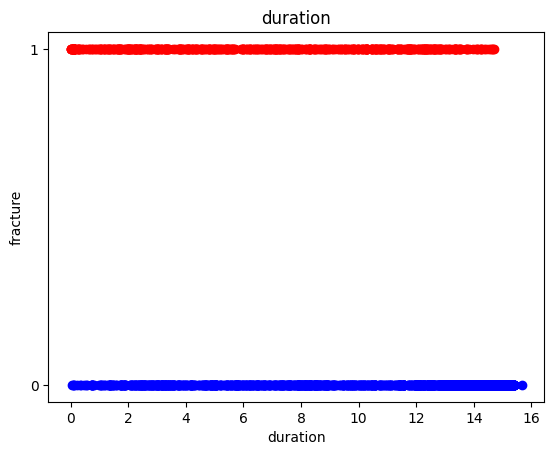

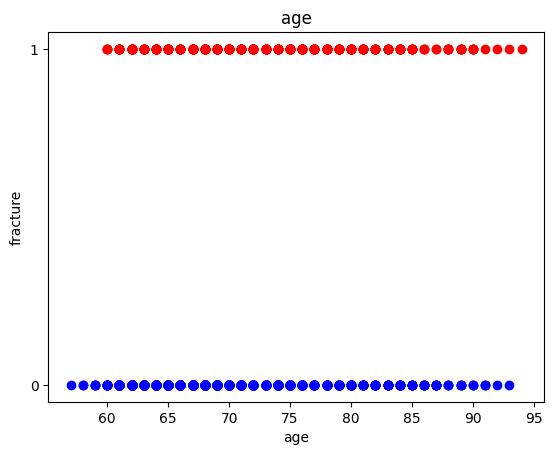

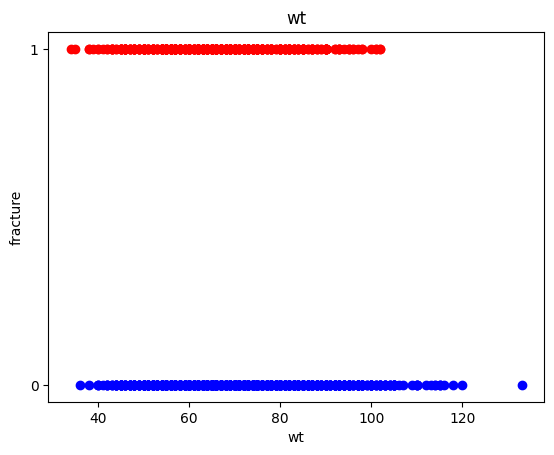

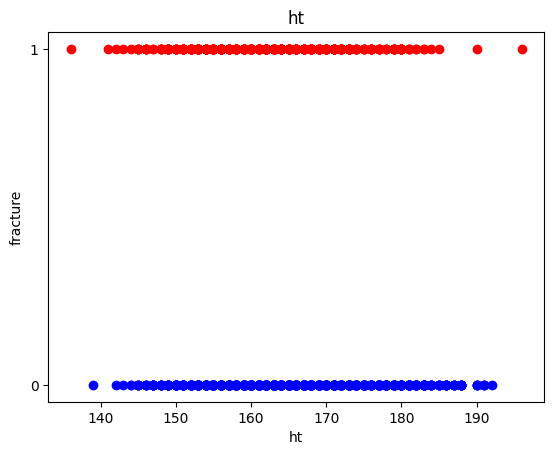

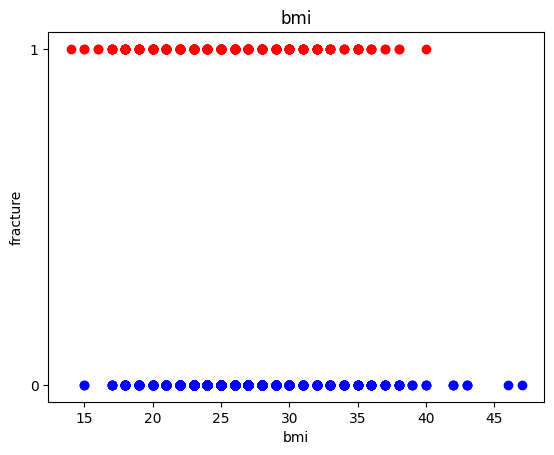

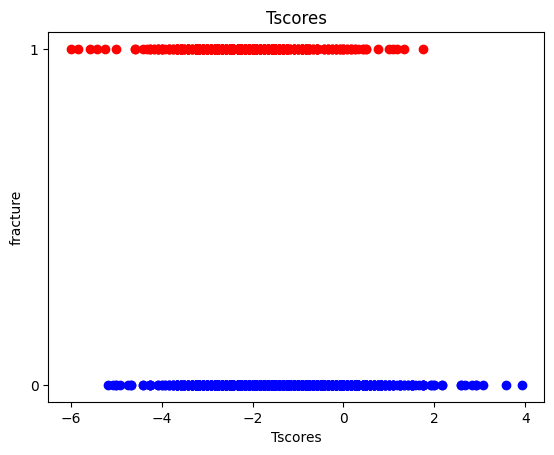

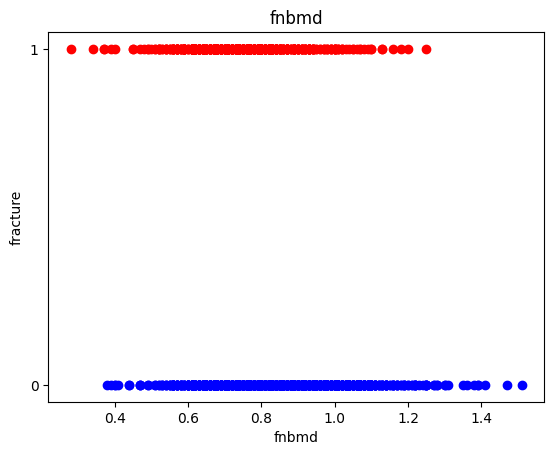

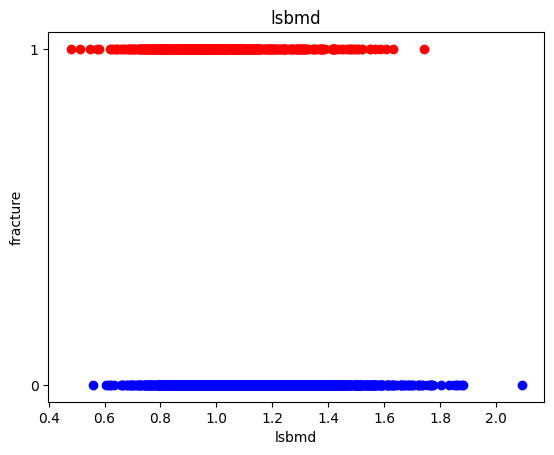

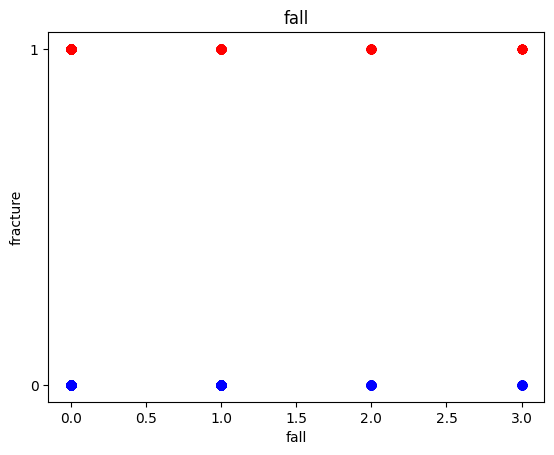

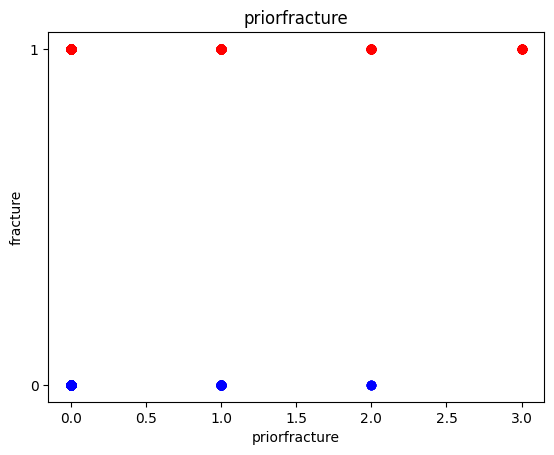

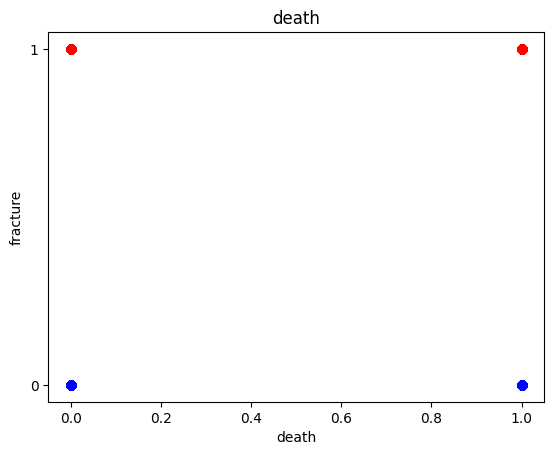

In [87]:
create_chart("duration")
create_chart("age")
create_chart("wt")
create_chart("ht")
create_chart("bmi")
create_chart("Tscores")
create_chart("fnbmd")
create_chart("lsbmd")
create_chart("fall")
create_chart("priorfracture")
create_chart("death")

## Separate two classes

In [124]:
dfs = [x for _, x in df.groupby('fracture')]
df1 = dfs[1].reset_index(drop=True)
df0 = dfs[0].reset_index(drop=True)

In [127]:
print(f"df1: {df1.shape}, df0: {df0.shape}")

df1: (528, 12), df0: (1566, 12)


### Assign class  number to each class

In [128]:
# df0["Class"] = 0
# df1["Class"] = 1

# Prepare train and test sets

80\% in train and 20\% in test

In [129]:
train_df0 = df0.iloc[0: int(len(df0)*0.8)]
train_df1 = df1.iloc[0: int(len(df1)*0.8)]

In [130]:
X_train_data = pd.concat([train_df0.drop(columns=["fracture"]), train_df1.drop(columns=["fracture"])]).reset_index(drop=True)
X_train_data

,sex,age,wt,ht,bmi,Tscores,fnbmd,lsbmd,fall,priorfracture,death
0,0,73,98.0,175.0,32.0,0.33,1.08,1.458,1,0,1
1,1,68,72.0,166.0,26.0,-0.25,0.97,1.325,0,0,0
2,0,68,87.0,184.0,26.0,-0.25,1.01,1.494,0,0,1
3,1,62,72.0,173.0,24.0,-1.33,0.84,1.214,0,0,0
4,0,61,72.0,173.0,24.0,-1.92,0.81,1.144,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1669,0,81,45.0,163.0,17.0,-5.42,0.39,0.750,0,2,1
1670,1,66,90.0,165.0,33.0,-0.75,0.91,1.259,0,2,1
1671,1,73,49.0,160.0,19.0,-3.25,0.61,0.789,0,2,0
1672,1,81,62.0,156.0,25.0,-3.58,0.57,0.962,0,3,0


In [131]:
y_train = pd.concat([train_df0["fracture"], train_df1["fracture"]]).to_numpy()
y_train

array([0, 0, 0, ..., 1, 1, 1], shape=(1674,))

In [132]:
test_df0 = df0.iloc[int(len(df0)*0.8):]
test_df1 = df1.iloc[int(len(df1)*0.8):]

In [133]:
X_test_data = pd.concat([test_df0.drop(columns=["fracture"]), test_df1.drop(columns=["fracture"])]).reset_index(drop=True)
y_test = pd.concat([test_df0["fracture"], test_df1["fracture"]]).to_numpy()

# Standardize the dataset

Before preparing the model, the entire dataset need to be standardized. Only train set mean and standard deviation are used to standardize the dataset to avoid potential bias. Each feature/attribute $(X_i)$ is subtracted by its mean $\mu$ and divided by its standard deviation $\sigma$. 

$\mu = \frac{1}{N} * X_i$\
$X_i = (X_i - \mu) / \sigma$

In [134]:
mean_train = X_train_data.mean()
std_train = X_train_data.std()

In [135]:
mean_train

sex                0.591995
age               70.391278
wt                70.594385
ht               165.458781
bmi               25.683990
Tscores           -1.512849
fnbmd              0.834779
lsbmd              1.114164
fall               0.324970
priorfracture      0.162485
death              0.376941
dtype: float64

In [136]:
std_train

sex               0.491611
age               6.763740
wt               14.118777
ht                9.256576
bmi               4.266652
Tscores           1.203539
fnbmd             0.151718
lsbmd             0.228737
fall              0.702321
priorfracture     0.504495
death             0.484765
dtype: float64

In [137]:
X_train_standard = (X_train_data - mean_train)/ std_train
X_train_standard.head()

,sex,age,wt,ht,bmi,Tscores,fnbmd,lsbmd,fall,priorfracture,death
0,-1.204195,0.385692,1.941076,1.030750,1.480320,1.531192,1.616293,1.503193,0.961141,-0.322075,1.285280
1,0.829934,-0.353544,0.099556,0.058469,0.074065,1.049280,0.891265,0.921739,-0.462709,-0.322075,-0.777576
2,-1.204195,-0.353544,1.161971,2.003032,0.074065,1.049280,1.154912,1.660579,-0.462709,-0.322075,1.285280
3,0.829934,-1.240627,0.099556,0.814688,-0.394687,0.151926,0.034413,0.436465,-0.462709,-0.322075,-0.777576
4,-1.204195,-1.388474,0.099556,0.814688,-0.394687,-0.338294,-0.163322,0.130437,-0.462709,-0.322075,-0.777576


In [138]:
X_train_standard = X_train_standard.to_numpy()
X_train_standard.shape

(1674, 11)

In [139]:
X_train = np.hstack([np.ones((X_train_standard.shape[0],1)), X_train_standard]) # add bias term
X_train.shape

(1674, 12)

In [140]:
X_test_standard = (X_test_data - mean_train)/ std_train
X_test_standard.head()

,sex,age,wt,ht,bmi,Tscores,fnbmd,lsbmd,fall,priorfracture,death
0,-1.204195,-0.501391,1.728593,1.786970,0.777192,0.492588,0.627618,-0.271772,-0.462709,-0.322075,1.285280
1,-1.204195,-1.388474,-0.325410,0.922719,-0.863438,0.218397,0.363971,-0.228054,-0.462709,-0.322075,-0.777576
2,-1.204195,-1.388474,-0.325410,0.058469,-0.394687,0.700309,0.825353,-0.149361,-0.462709,-0.322075,1.285280
3,-1.204195,1.124928,1.091144,1.246813,0.308441,-0.130574,0.034413,0.169783,-0.462709,-0.322075,1.285280
4,0.829934,-0.057849,-0.396237,0.166500,-0.629062,-0.055794,-0.163322,-0.529710,-0.462709,-0.322075,-0.777576


In [141]:
X_test_standard = X_test_standard.to_numpy()
X_test_standard.shape

(420, 11)

In [142]:
X_test = np.hstack([np.ones((X_test_standard.shape[0],1)), X_test_standard]) # add bias term
X_test.shape

(420, 12)

## Training

Weights: [[-1.19349992  0.47858277  0.11663445 -0.07936943  0.34455829  0.10974276
  -0.23559561 -0.10930951 -0.1694706   0.07305846  1.25203211  0.08476339]]


Text(0, 0.5, 'Loss')

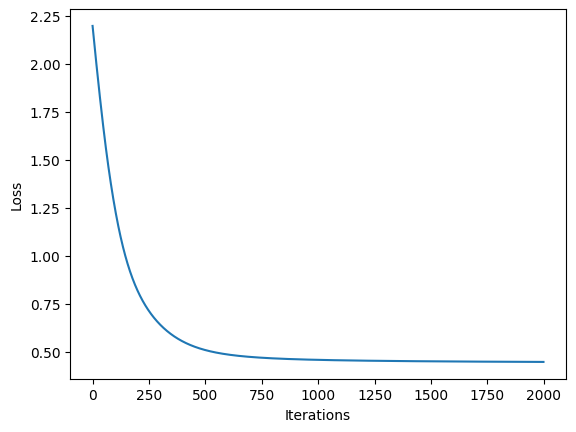

In [147]:
epochs = 2000
learning_rate = 0.00001
lg = LogisticRegression()
lg.fit(X_train, y_train, epochs = epochs, learning_rate = learning_rate)
w_offline, cost_list_offline = lg.w, lg.cost_list
print(f"Weights: {w_offline}")
plt.plot(cost_list_offline)
plt.xlabel("Iterations")
plt.ylabel("Loss")

In [148]:
y_pred = lg.prediction(X_test)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,

In [149]:
y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [150]:
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.2%}")

Accuracy: 73.33%
